# Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy_sz import Class
import classy_sz
classy_sz.__file__

Metal device set to: Apple M1 Pro


2023-04-11 23:16:43.633206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 23:16:43.633328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/Users/boris/opt/miniconda3/lib/python3.9/site-packages/classy_sz-2.9.4-py3.9-macosx-11.0-arm64.egg/classy_sz.cpython-39-darwin.so'

In [2]:
#plotting settings
plot_params= {
    'figure.figsize': (8,6),
    'axes.labelsize': 15,
    'axes.grid': True,
    'grid.alpha': 0.2,
    'grid.linestyle':'--',
    'axes.grid.which': 'both',
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 13,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.major.size': 7,
    'xtick.minor.size': 3,
    'ytick.major.size': 7,
    'ytick.minor.size': 3,
    'axes.titlesize': 20,
    'xtick.major.size':5,
    'ytick.major.size':5,
    'xtick.major.pad':10,
    'ytick.major.pad':5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    
}
plt.rcParams.update(plot_params)

In [3]:
# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06}

In [4]:
zmin=0.0
zmax=15.
param_dict={
    'output':'mPk,dndlnM,lens_lens_hf,lCl',
    'non_linear': 'hmcode',
    'z_min':zmin,
    'z_max':zmax,
    'z_max_pk':15.,
 'ell_max': 20000.0,
 'ell_min': 2.0,
 'dlogell': 0.1,
    
    # 'output': 'lCl',
    'l_max_scalars':10000.,
    'non_linear':'halofit',
    'perturb_sampling_stepsize' : 0.005,
    'k_max_tau0_over_l_max':5.,    

       }

In [5]:
%%time
# this takes a long time because of class lensing calculations (not because of class_sz)
M = Class()
M.set(cosmo_params)
M.set(param_dict)
M.compute()
kappa_kernel = np.vectorize(M.get_dkappacmbdz_at_l_and_z)
pknl = np.vectorize(M.get_pk_nonlin_at_k_and_z)

CPU times: user 2min 16s, sys: 1.89 s, total: 2min 18s
Wall time: 21 s


In [6]:
kappa_kernel(10.,10)

array(3.60291301e-10)

In [7]:
pknl(1e10,0.)

array(0.)

In [8]:
kappa_ls = np.asarray(M.cl_kk()['ell'])

fac = kappa_ls*(kappa_ls+1.)/2./np.pi
kappa_cls = np.asarray(M.cl_kk()['hf'])/fac

In [9]:
class_ls = M.raw_cl()['ell']
class_cls = M.raw_cl()['pp']*(M.raw_cl()['ell']*(M.raw_cl()['ell']+1.)/2.)**2.

In [10]:
from scipy.interpolate import interp1d

In [12]:
z_array_2d = np.linspace(0.01,15,600)

# Let's try Anthony's suggestion

## the kernel itself

In [11]:
l = np.linspace(50,2000,500)
kappa_2dnonlin = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2dnonlin[izp,ilq] = kappa_kernel(lm,zp,use_pklin=0)#/np.exp(kappa_cl_interp(np.log(lm))) 
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1

Text(0, 0.5, 'Redshift $z$')

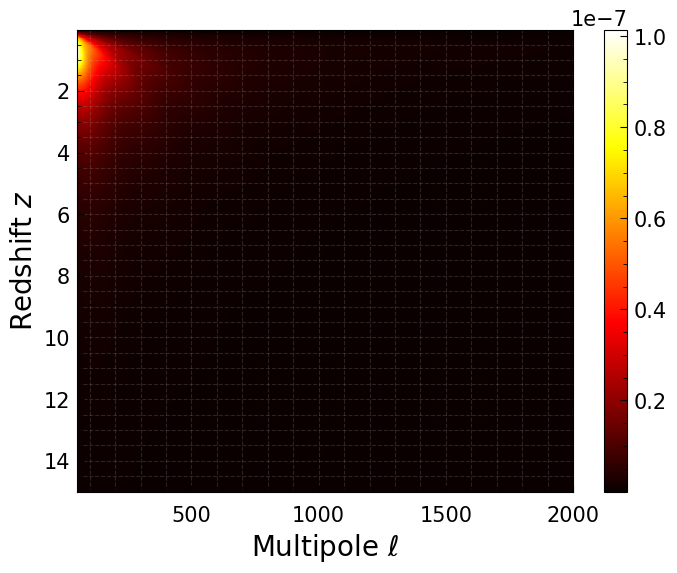

In [12]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dnonlin, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)
# plt.show()
# plt.title('Lensing Kernel $C_\ell/dz$') # volume is c^ch2/H
# plt.savefig('figures/kappa_kernel_heatmap_integrand_nonorm_withlog_pknonlin_highl.pdf')

Now for each, rather we integrate the kernel until that z:

In [17]:
%%time
kappa_2dnonlin_integrated = np.zeros((600,500))
izp = 0
ilq = 0
zp_fine = np.linspace(0.01,15,600)
for zp in z_array_2d:
    ilq=0
    for lm in l:
        if zp == z_array_2d[0]:
            kappa_2dnonlin_integrated[izp,ilq] = 0.
        else:
            kappa_2dnonlin_integrated[izp,ilq] = np.trapz(kappa_kernel(lm,zp_fine[zp_fine<zp],use_pklin=0),x=zp_fine[zp_fine<zp])
        ilq+=1
    izp+=1

CPU times: user 35min 56s, sys: 4.03 s, total: 36min
Wall time: 37min 29s


Text(0, 0.5, 'Redshift $z$')

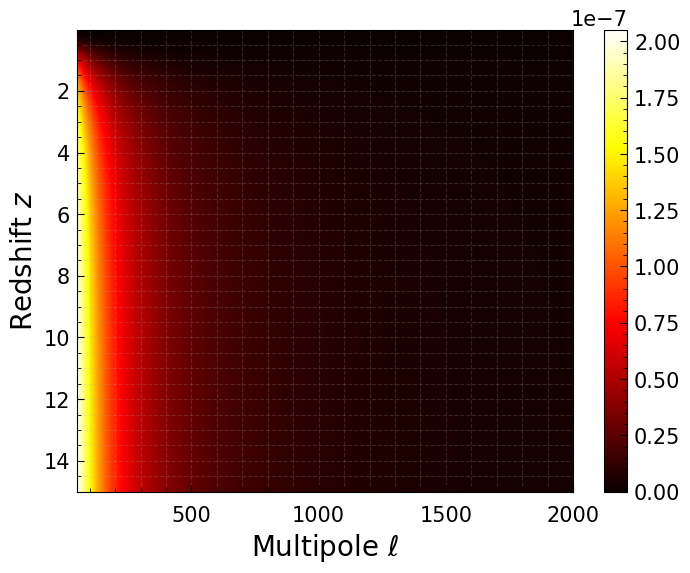

In [18]:
im = plt.imshow(kappa_2dnonlin_integrated, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)

now that we have the integrated kernel,
we can first compare with actuall clkk:

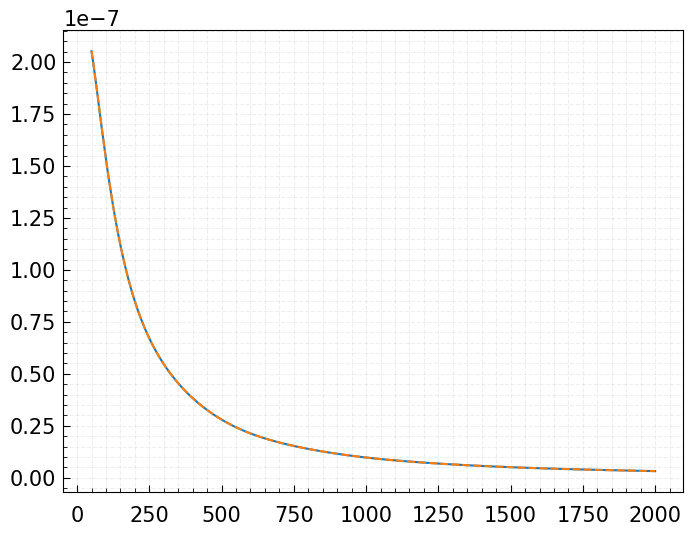

In [26]:
from scipy.interpolate import interp1d

kappa_ls = np.asarray(M.cl_kk()['ell'])

fac = kappa_ls*(kappa_ls+1.)/2./np.pi
kappa_cls = np.asarray(M.cl_kk()['hf'])/fac
kappa_cl_interp = interp1d(np.log(kappa_ls),np.log(kappa_cls),bounds_error=False,fill_value = 'extrapolate')

plt.plot(l,np.exp(kappa_cl_interp(np.log(l))) )
plt.plot(l,kappa_2dnonlin_integrated[599,:],ls='--')

that looks good. Now we can divid by the error at each l

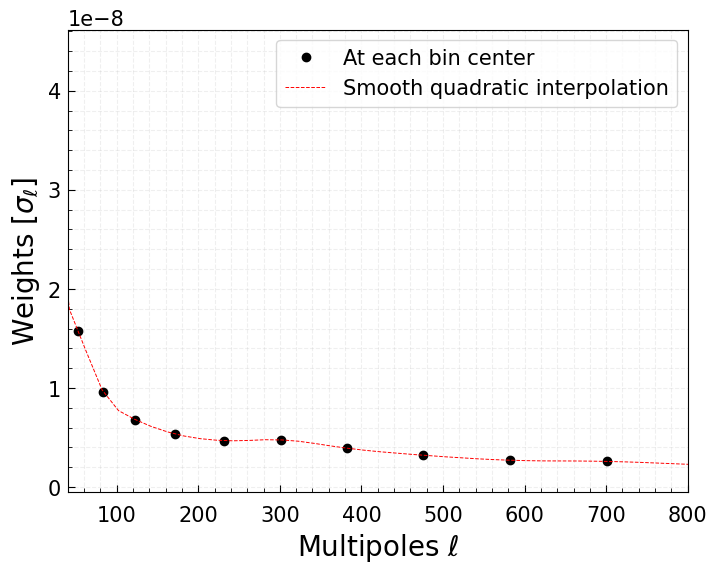

In [14]:
bins=np.array([  14.5,   30.5,   53. ,   83.5,  123. ,  172. ,  231.5,  301.5,
        382.5,  476. ,  582. ,  700.5,  832.5, 1001. , 1200. , 1400. ,
       1600. , 1874. ])
data_err=np.array([4.40528654e-08, 2.37125183e-08, 1.57328003e-08, 9.60120565e-09,
       6.80489953e-09, 5.35635794e-09, 4.69542737e-09, 4.76293843e-09,
       3.92905083e-09, 3.21649991e-09, 2.71631720e-09, 2.59452103e-09,
       2.19305060e-09, 1.83861369e-09, 1.71396071e-09, 1.68440558e-09,
       1.90900693e-09, 2.55426249e-09])
data_clkk=np.array([0.,0.,2.27995494e-07, 1.73923453e-07, 1.33500474e-07, 9.90770721e-08,
       7.65258609e-08, 6.26104616e-08, 4.61895442e-08, 4.12141618e-08,
       2.43162623e-08, 1.57515579e-08,0.,0.,0.,0.,0.,0.])
errors = data_err#/np.exp(kappa_cl_interp(np.log(bins)))
# errors = data_err/data_clkk
ws = errors

kappa_errors = interp1d(bins,ws,kind='quadratic',bounds_error=False,fill_value=np.inf)
ls = np.linspace(2,10000,500)
plt.plot(bins,errors,c='k',marker='o',ls='None',label='At each bin center')
plt.plot(ls,kappa_errors(ls),ls='--',c='r',lw=0.7,label='Smooth quadratic interpolation')
plt.xlim(40.,800.)
# plt.ylim(0.,1.025)
# plt.title('kappa weights at all ells')
plt.xlabel('Multipoles $\ell$',size=20)
plt.ylabel('Weights $[\sigma_\ell]$',size=20)
plt.legend(frameon=True,loc=1,fontsize = 15)
# plt.savefig('figures/weights_kk.pdf')

In [37]:
1/np.inf

0.0

In [38]:
%%time
kappa_2dnonlin_integrated_divided_by_error_and_squared = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2dnonlin_integrated_divided_by_error_and_squared[izp,ilq] = (kappa_2dnonlin_integrated[izp,ilq]/kappa_errors(lm))**2
        ilq+=1
    izp+=1

CPU times: user 2.7 s, sys: 18.8 ms, total: 2.72 s
Wall time: 2.78 s


Text(0, 0.5, 'Redshift $z$')

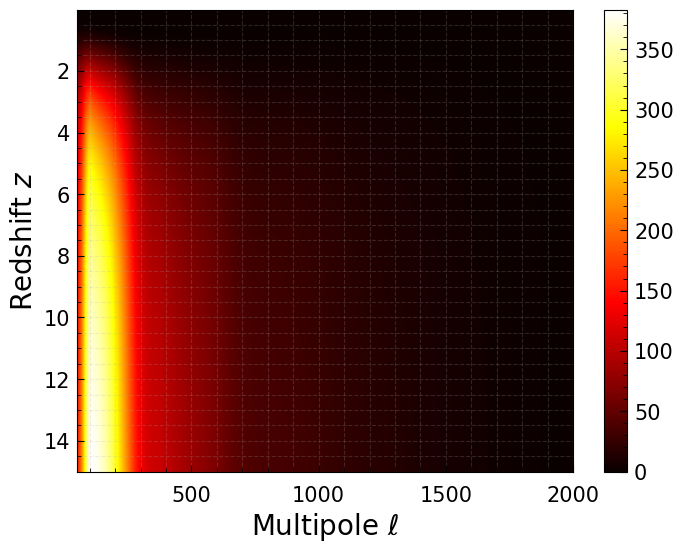

In [39]:
im = plt.imshow(kappa_2dnonlin_integrated_divided_by_error_and_squared, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)

Now we can average over all multipoles to get the z curve

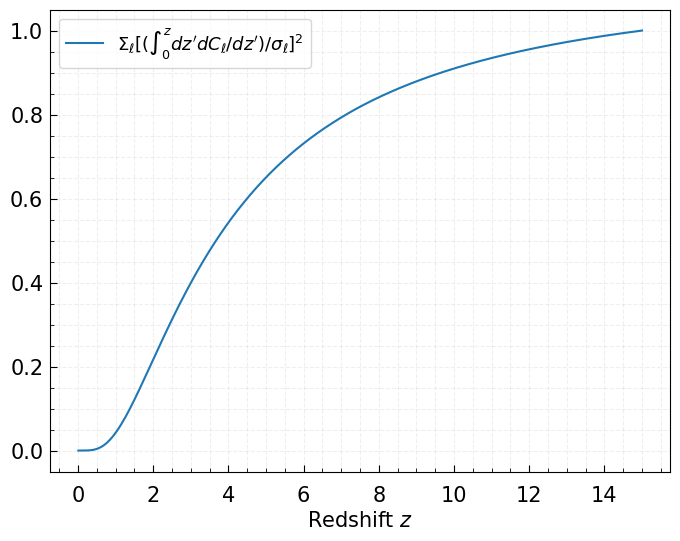

In [48]:
kappa_z_snr = np.zeros(len(z_array_2d))
for izp,zp in enumerate(z_array_2d):
    kappa_z_snr[izp] = np.sum(kappa_2dnonlin_integrated_divided_by_error_and_squared[izp,:])
    # kappa_z[izp] = np.sum(kappa_2dw[:,izp])
    
wz_snr = kappa_z_snr/kappa_z_snr.max()
plt.plot(z_array_2d,wz_snr,label=r'$\Sigma_\ell [(\int_0^z dz^\prime dC_\ell/dz^\prime)/\sigma_\ell]^2$')
plt.xlabel('Redshift $z$')
plt.legend()
plt.savefig('anthony_kernel_suggestion.pdf')

[]

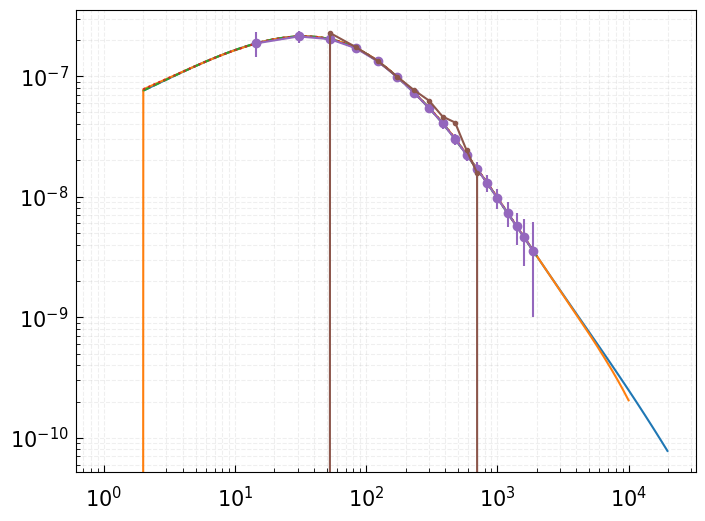

In [15]:

plt.plot(kappa_ls,kappa_cls)
plt.plot(class_ls,class_cls)

kappa_cl_interp = interp1d(np.log(kappa_ls),np.log(kappa_cls),bounds_error=False,fill_value = 'extrapolate')

class_cl_interp = interp1d(np.log(class_ls[2:]),np.log(class_cls[2:]),bounds_error=False,fill_value = 'extrapolate')
ls = np.linspace(2,2000,2000)
plt.plot(ls,np.exp(kappa_cl_interp(np.log(ls))),ls='--')
plt.plot(ls,np.exp(class_cl_interp(np.log(ls))),ls=':')

plt.errorbar(bins,np.exp(kappa_cl_interp(np.log(bins))),yerr= data_err,marker='o') # comment this if you dont have the data
plt.errorbar(bins,data_clkk,marker='.') # comment if you dont have the data
plt.loglog()

# lensing kernel strictly the integrand, pklin vs nonlin

In [312]:
%%time
z_array_2d = np.linspace(0.01,15,600)
l = np.linspace(50,2000,500)
kappa_2dlin = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2dlin[izp,ilq] = kappa_kernel(lm,zp,use_pklin=1)/np.exp(kappa_cl_interp(np.log(lm))) 
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
# kappa_2d = kappa_2d.max()
# ilq = 0
# for lm in l:
#     kappa_2d[:,ilq] = kappa_2d[:,ilq]/kappa_2d[:,ilq].max()
#     ilq+=1

CPU times: user 20 s, sys: 367 ms, total: 20.4 s
Wall time: 20.1 s


In [313]:
%%time
# z_array_2d = np.linspace(0.01,15,600)
l = np.linspace(50,2000,500)
kappa_2dnonlin = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2dnonlin[izp,ilq] = kappa_kernel(lm,zp,use_pklin=0)/np.exp(kappa_cl_interp(np.log(lm))) 
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
# kappa_2d = kappa_2d.max()
# ilq = 0
# for lm in l:
#     kappa_2d[:,ilq] = kappa_2d[:,ilq]/kappa_2d[:,ilq].max()
#     ilq+=1

CPU times: user 20 s, sys: 449 ms, total: 20.5 s
Wall time: 20.1 s


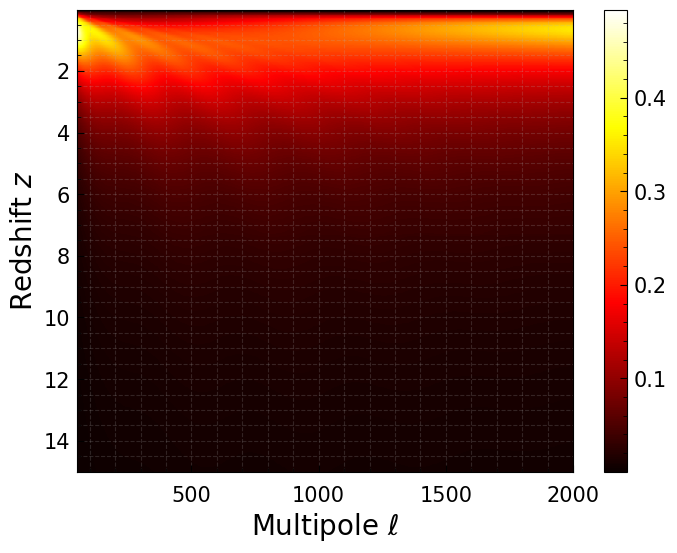

In [314]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dnonlin, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)
# plt.show()
# plt.title('Lensing Kernel $C_\ell/dz$') # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap_integrand_nonorm_withlog_pknonlin_highl.pdf')

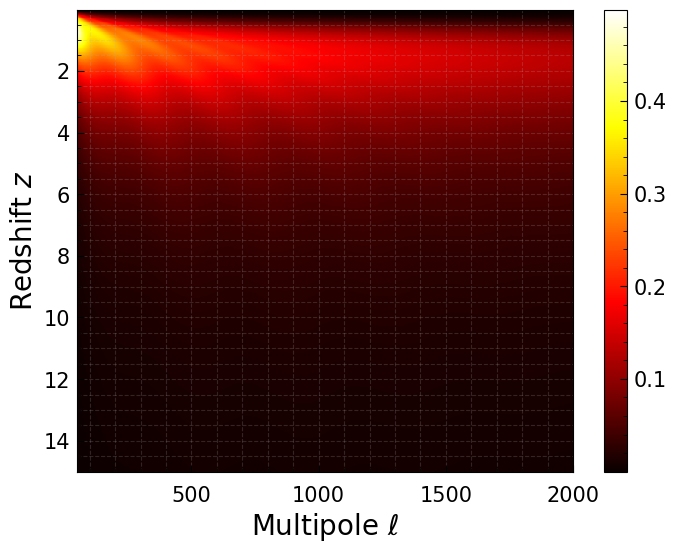

In [315]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dlin, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)
# plt.show()
# plt.title('Lensing Kernel $C_\ell/dz$') # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap_integrand_nonorm_withlog_pklin_highl.pdf')

# lensing kernel strictly the integrand:

In [18]:
%%time
z_array_2d = np.linspace(0.01,15,600)
l = np.linspace(50,800,500)
kappa_2d = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2d[izp,ilq] = kappa_kernel(lm,zp)/np.exp(kappa_cl_interp(np.log(lm))) 
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
# kappa_2d = kappa_2d.max()
# ilq = 0
# for lm in l:
#     kappa_2d[:,ilq] = kappa_2d[:,ilq]/kappa_2d[:,ilq].max()
#     ilq+=1

CPU times: user 19.1 s, sys: 310 ms, total: 19.4 s
Wall time: 19.3 s


Text(0, 0.5, 'Redshift $z$')

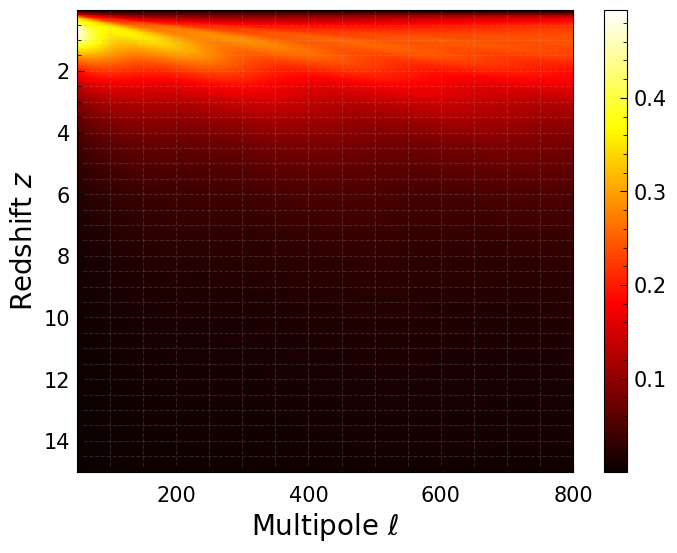

In [19]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)
# plt.show()
# plt.title('Lensing Kernel $C_\ell/dz$') # volume is c^ch2/H
# plt.savefig('figures/kappa_kernel_heatmap_integrand_nonorm_withlog.pdf')

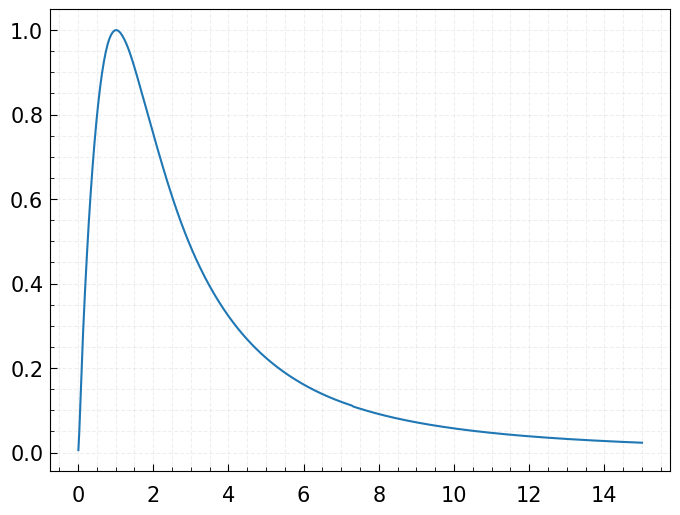

In [20]:
kappa_z = np.zeros(len(z_array_2d))
for izp,zp in enumerate(z_array_2d):
    kappa_z[izp] = np.sum(kappa_2d[izp,:])
    # kappa_z[izp] = np.sum(kappa_2dw[:,izp])
    
wz_notdataweighted = kappa_z/kappa_z.max()
plt.plot(z_array_2d,wz_notdataweighted)
# plt.title('log')

Text(0.5, 1.0, 'Lensing Kernel $C_\\ell/dz$ (norm.)')

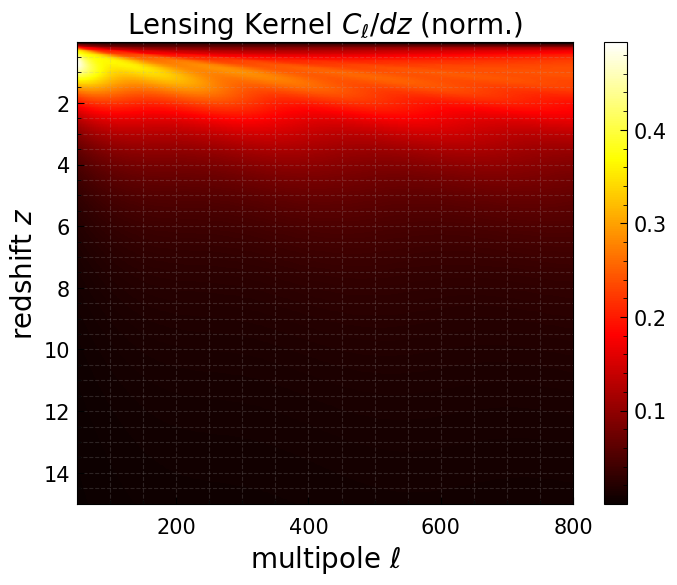

In [21]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $C_\ell/dz$ (norm.)') # volume is c^ch2/H
# plt.savefig('figures/kappa_kernel_heatmap_integrand.pdf')

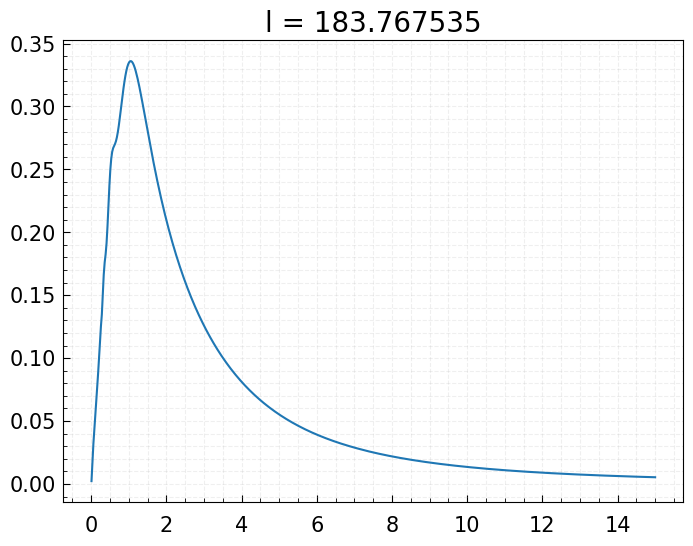

In [22]:

# plot one slice:
ilp = 89
plt.title("l = %f"%l[ilp])
plt.plot(z_array_2d,kappa_2d[:,ilp])

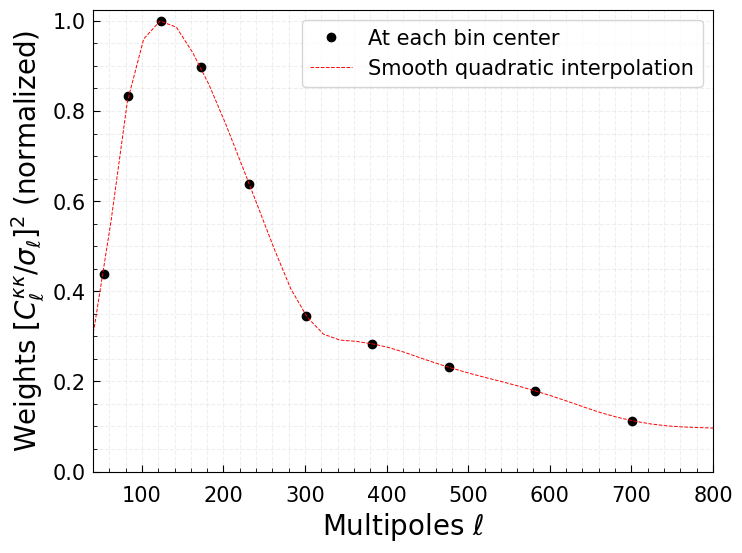

In [23]:
bins=np.array([  14.5,   30.5,   53. ,   83.5,  123. ,  172. ,  231.5,  301.5,
        382.5,  476. ,  582. ,  700.5,  832.5, 1001. , 1200. , 1400. ,
       1600. , 1874. ])
data_err=np.array([4.40528654e-08, 2.37125183e-08, 1.57328003e-08, 9.60120565e-09,
       6.80489953e-09, 5.35635794e-09, 4.69542737e-09, 4.76293843e-09,
       3.92905083e-09, 3.21649991e-09, 2.71631720e-09, 2.59452103e-09,
       2.19305060e-09, 1.83861369e-09, 1.71396071e-09, 1.68440558e-09,
       1.90900693e-09, 2.55426249e-09])
data_clkk=np.array([0.,0.,2.27995494e-07, 1.73923453e-07, 1.33500474e-07, 9.90770721e-08,
       7.65258609e-08, 6.26104616e-08, 4.61895442e-08, 4.12141618e-08,
       2.43162623e-08, 1.57515579e-08,0.,0.,0.,0.,0.,0.])
errors = data_err/np.exp(kappa_cl_interp(np.log(bins)))
# errors = data_err/data_clkk
ws = 1./errors**2

kappa_weights = interp1d(bins,ws/ws.max(),kind='quadratic',bounds_error=False,fill_value=np.nan)
ls = np.linspace(2,10000,500)
plt.plot(bins,1./errors**2/ws.max(),c='k',marker='o',ls='None',label='At each bin center')
plt.plot(ls,kappa_weights(ls),ls='--',c='r',lw=0.7,label='Smooth quadratic interpolation')
plt.xlim(40.,800.)
plt.ylim(0.,1.025)
# plt.title('kappa weights at all ells')
plt.xlabel('Multipoles $\ell$',size=20)
plt.ylabel('Weights $[C^{\kappa\kappa}_\ell/\sigma_\ell]^2$ (normalized)',size=20)
plt.legend(frameon=True,loc=1,fontsize = 15)
plt.savefig('figures/weights_kk.pdf')

# lensing kernel strictly the integrand with weights!

In [24]:
%%time
# z_array_2d = np.linspace(0.01,8,600)
l = np.linspace(50,800,500)
kappa_2dw = np.zeros((600,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        # kappa_2dw[izp,ilq] = kappa_kernel(lm,zp)*kappa_weights(lm)#/np.exp(kappa_cl_interp(np.log(lm)))*kappa_weights(lm)
        kappa_2dw[izp,ilq] = kappa_kernel(lm,zp)*kappa_weights(lm)/np.exp(kappa_cl_interp(np.log(lm)))#*kappa_weights(lm)
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
# kappa_2d = kappa_2d.max()
# ilq = 0
# for lm in l:
#     kappa_2dw[:,ilq] = kappa_2dw[:,ilq]/kappa_2d[:,ilq].max()
#     # kappa_2dw[:,ilq] = kappa_2dw[:,ilq]/kappa_2dw[:,ilq].max()
#     ilq+=1

CPU times: user 21.7 s, sys: 325 ms, total: 22.1 s
Wall time: 21.9 s


Text(0, 0.5, 'Redshift $z$')

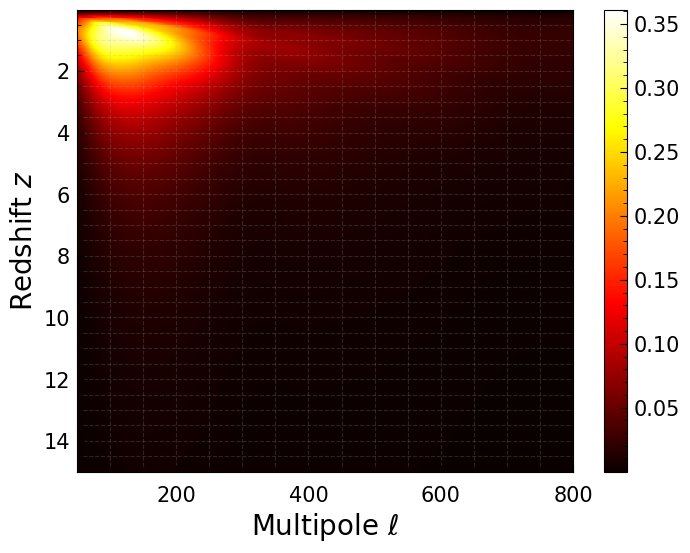

In [25]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dw, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('Multipole $\ell$',size=20)
plt.ylabel('Redshift $z$',size=20)
# plt.show()
# plt.title('Lensing Kernel $dln C_\ell/dz$ data-weighted',size=15) # volume is c^ch2/H
# plt.savefig('figures/kappa_kernel_heatmap_integrand_dataweighted_nonorm_log.pdf')

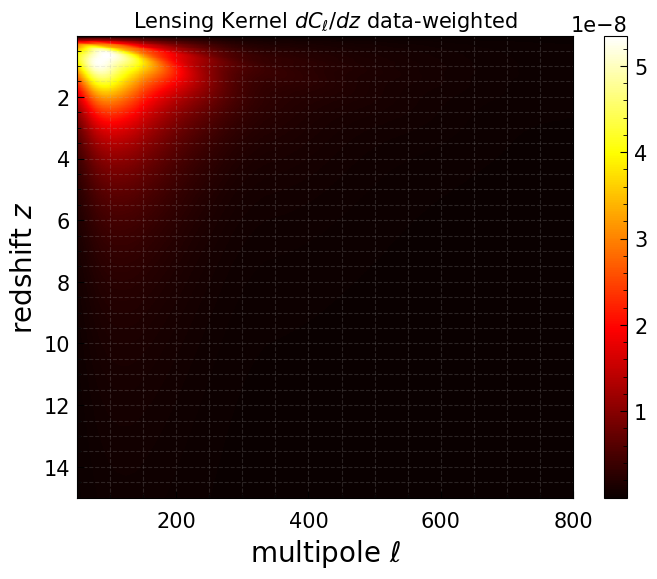

In [230]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dw, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $dC_\ell/dz$ data-weighted',size=15) # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap_integrand_dataweighted_nonorm.pdf')

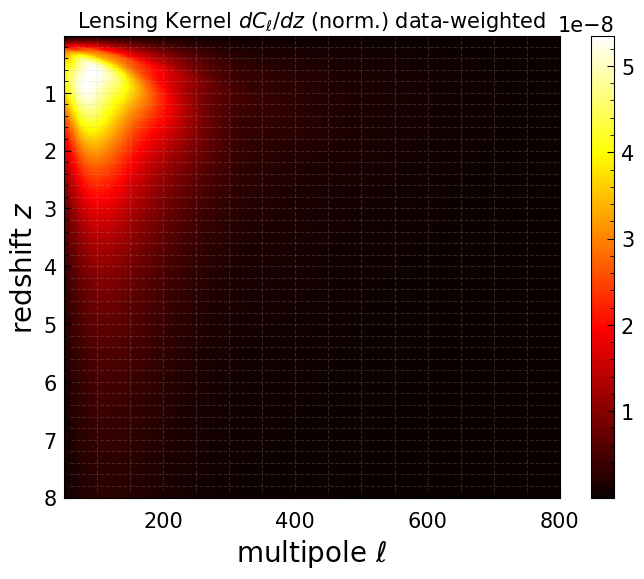

In [166]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2dw, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $dC_\ell/dz$ (norm.) data-weighted',size=15) # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap_integrand_dataweighted.pdf')

Text(0.5, 1.0, 'log')

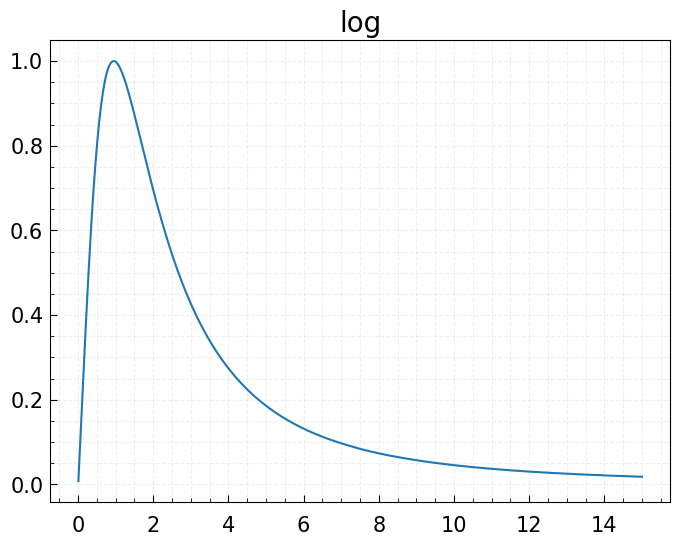

In [26]:
kappa_z = np.zeros(len(z_array_2d))
for izp,zp in enumerate(z_array_2d):
    kappa_z[izp] = np.sum(kappa_2dw[izp,:])
    # kappa_z[izp] = np.sum(kappa_2dw[:,izp])
    
wz_dataweighted = kappa_z/kappa_z.max()
plt.plot(z_array_2d,wz_dataweighted)
plt.title('log')

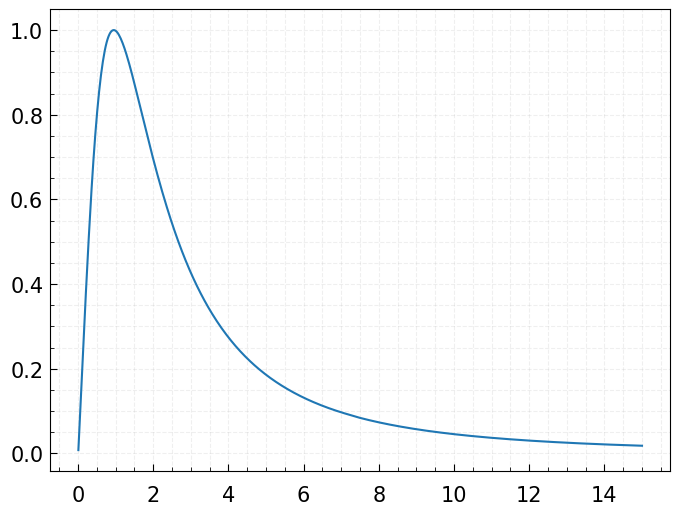

In [27]:
kappa_z = np.zeros(len(z_array_2d))
for izp,zp in enumerate(z_array_2d):
    kappa_z[izp] = np.sum(kappa_2dw[izp,:])
    # kappa_z[izp] = np.sum(kappa_2dw[:,izp])
    
wz_dataweighted = kappa_z/kappa_z.max()
plt.plot(z_array_2d,wz_dataweighted)

In [29]:
# np.savetxt('save_lensingkernel_asinpaper_110423.txt',np.c_[z_array_2d,wz_dataweighted])

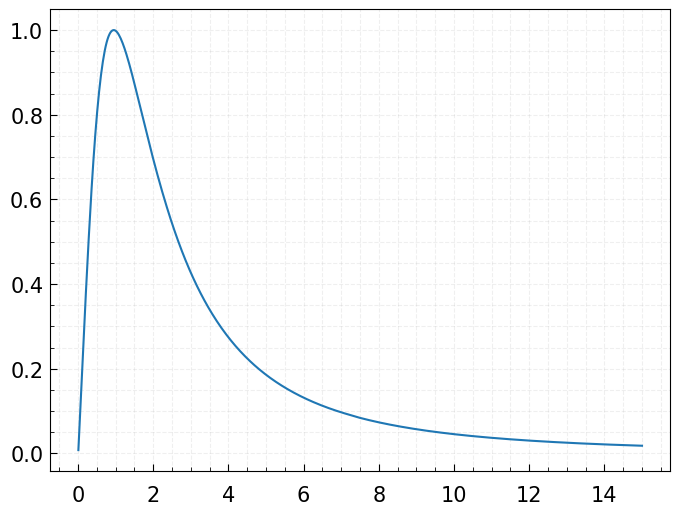

In [31]:
zl,wzl = np.loadtxt('save_lensingkernel_asinpaper_110423.txt',unpack=True)
plt.plot(zl,wzl)

# lensing kernel strictly the integrand but with Pk

In [13]:
%%time
z_array_2d = np.linspace(0.01,8,500)
l = np.linspace(50,2000,500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2d[izp][ilq] = kappa_kernel(lm,zp,use_pklin=1)/np.exp(kappa_cl_interp(np.log(lm))) # we multiply by volume to remove the volume factor
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
kappa_2d = kappa_2d/kappa_2d.max()

CPU times: user 16.7 s, sys: 314 ms, total: 17 s
Wall time: 16.9 s


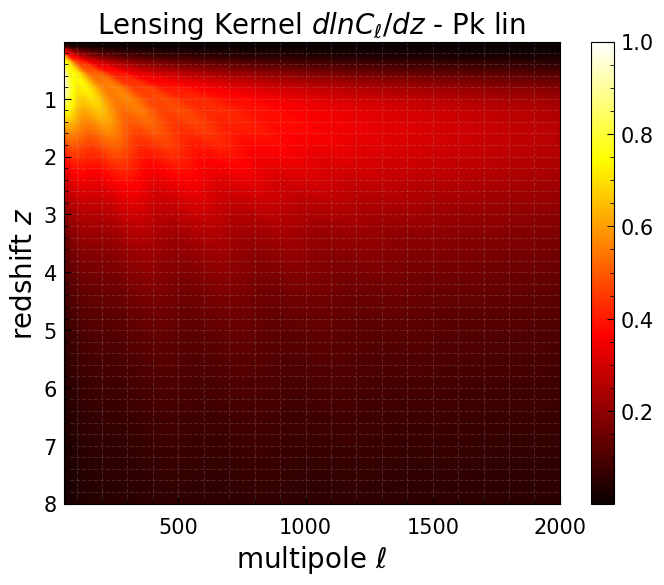

In [15]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $dln C_\ell/dz$ - Pk lin') # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap_integrand_pklin.pdf')

# lensing kernel times volume

In [314]:
%%time
z_array_2d = np.linspace(0.01,8,500)
l = np.linspace(50,2000,500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(kappa_cl_interp(np.log(lm))) # we multiply by volume to remove the volume factor
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
kappa_2d = kappa_2d/kappa_2d.max()

CPU times: user 16.1 s, sys: 464 ms, total: 16.6 s
Wall time: 16.2 s


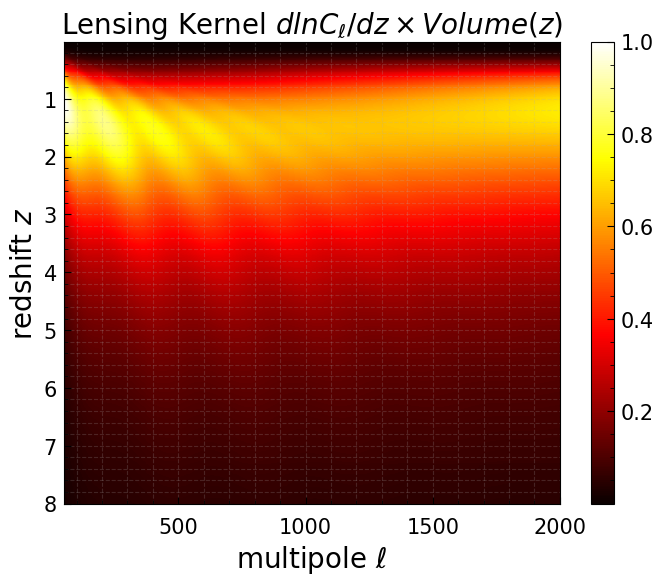

In [315]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title(r'Lensing Kernel $dln C_\ell/dz \times Volume(z)$') # volume is c^ch2/H
plt.savefig('figures/kappa_kernel_heatmap.pdf')

# lensing kernel in k's

In [320]:
%%time
z_array_2d = np.linspace(0.01,8,500)
lnk = np.linspace(np.log10(1e-2),np.log10(10),500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lnkp in lnk:
        kp = 10.**(lnkp)
        chi = M.angular_distance(zp)*(1+zp)*M.h()
        lm = kp*chi#-0.5
        if lm<50:
            rk = 0.
        # print(lm)
        # if lm<0:
        #     kappa_2d[izp][ilq] = 0.
        #     ilq+=1
        #     continue
        # try:
        # rk = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(kappa_cl_interp(np.log(lm)))
        else:
            rk = kappa_kernel(lm,zp)/np.exp(kappa_cl_interp(np.log(lm)))
            if np.isnan(rk):
                rk = 0.
        kappa_2d[izp][ilq] = rk
        # except ValueError:
        #     kappa_2d[izp][ilq] = 0.
        # kappa_2d[izp][ilq] = kappa_kernel(lm,zp)*M.get_volume_dVdzdOmega_at_z(zp)/np.exp(class_cl_interp(np.log(lm)))
        ilq+=1
    izp+=1
    
kappa_2d = kappa_2d/kappa_2d.max()

CPU times: user 15.5 s, sys: 237 ms, total: 15.7 s
Wall time: 15.6 s


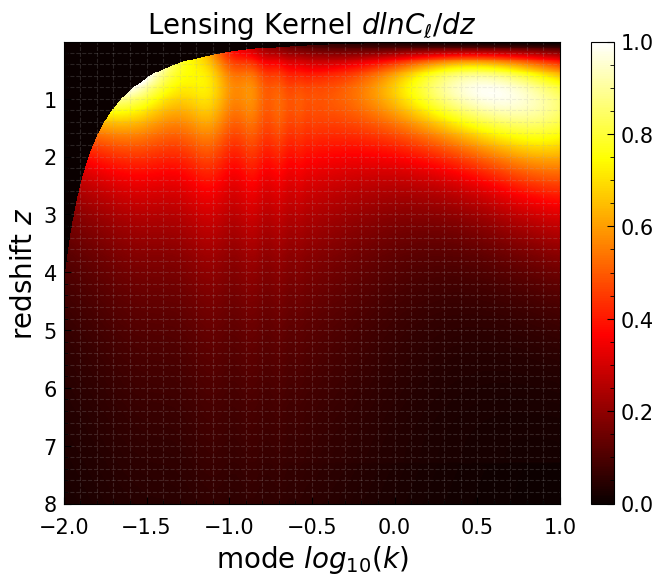

In [321]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', interpolation='nearest',
                extent = [lnk[0],lnk[-1],z_array_2d[-1],z_array_2d[0]],
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('mode $log_{10}(k)$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $dln C_\ell/dz$')
plt.savefig('figures/kappa_kernel_heatmap_ks.pdf')

# lensing kernel W(z)

In [232]:
M.angular_distance(1e-4)

0.4429869971248203

In [233]:
%%time
# z_array_2d = np.linspace(0.01,8,600)
l = np.linspace(2,100,50)
kappa_2d_wz = np.zeros((600,50))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        chi = M.angular_distance(zp)*(1+zp)*M.h()
        kl = (lm+0.5)/chi
        kappa_2d_wz[izp,ilq] = np.sqrt(kappa_kernel(lm,zp)/pknl(kl,zp)*M.get_volume_dVdzdOmega_at_z(zp))
        ilq+=1
    izp+=1

CPU times: user 2.88 s, sys: 15.6 ms, total: 2.9 s
Wall time: 2.9 s


In [234]:
kappa_2d.min()

8.936422508063686e-12

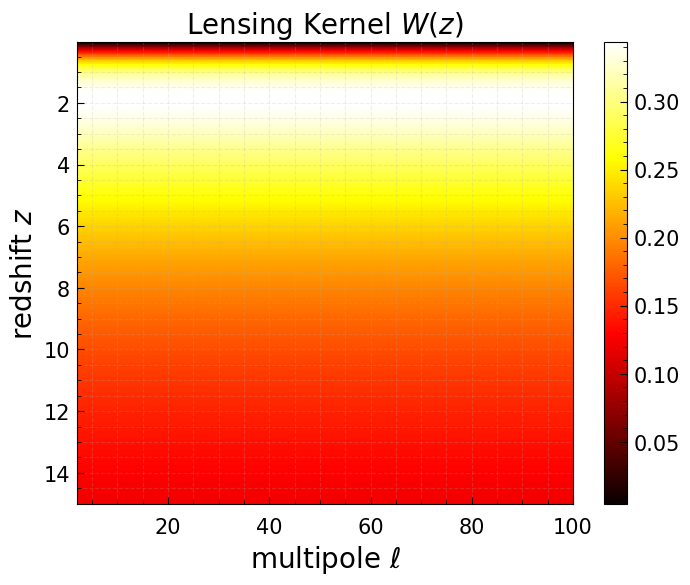

In [235]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d_wz, cmap='hot', 
                interpolation='nearest',
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $W(z)$')
plt.savefig('figures/kappa_kernel_Wz_heatmap.pdf')

In [236]:
# kappa_2d[:,10]

(0.1, 10.0)

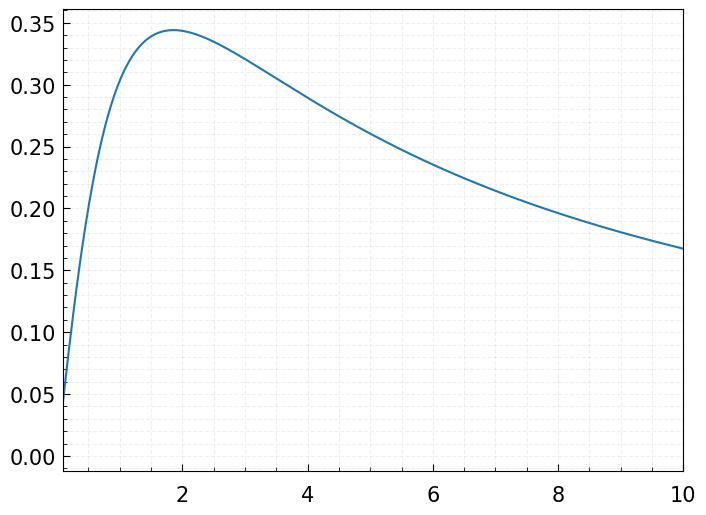

In [237]:
# plt.plot(z_array_2d,kappa_2d[:,10]**2/np.vectorize(M.get_volume_dVdzdOmega_at_z)(z_array_2d))
plt.plot(z_array_2d,kappa_2d_wz[:,10])

# plt.xscale('log')
plt.xlim(1e-1,1e1)

In [238]:
zwz = z_array_2d.copy()
wz_trad = kappa_2d_wz[:,10].copy()

In [283]:
z_array_2d[np.where(wz_dataweighted==wz_dataweighted.max())[0]]

array([0.96095159])

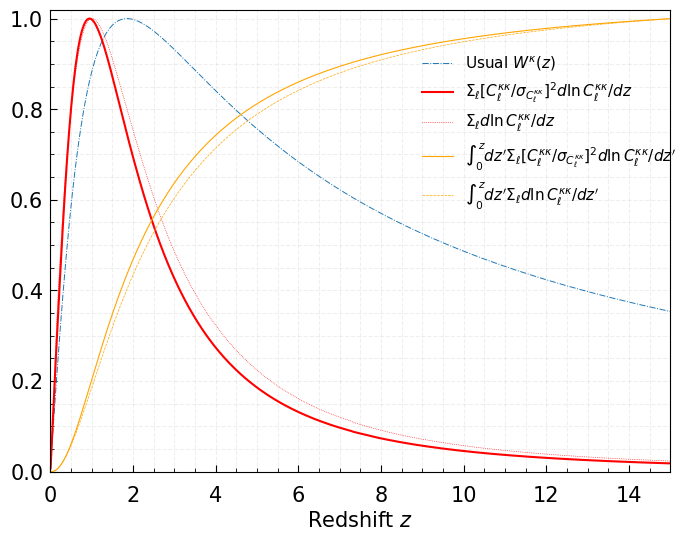

In [376]:
plt.plot(zwz,wz_trad/wz_trad.max(),label='Usual $W^{\kappa}(z)$',ls='-.',lw=0.7)
plt.plot(z_array_2d,wz_dataweighted,label=r'$\Sigma_\ell [C^{\kappa\kappa}_\ell/\sigma_{C^{\kappa\kappa}_\ell}]^2 d\ln C^{\kappa\kappa}_\ell/dz$',c='r')
plt.plot(z_array_2d,wz_notdataweighted,label=r'$\Sigma_\ell d\ln C^{\kappa\kappa}_\ell/dz$',c='r',lw=0.5,ls=':')

totc = np.trapz(wz_dataweighted,z_array_2d)
wz_dataweighted_c =[]
for zp in z_array_2d:
    wz_dataweighted_c.append(np.trapz(wz_dataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
plt.plot(z_array_2d,wz_dataweighted_c,label='$\int_0^z dz^\prime \Sigma_\ell [C^{\kappa\kappa}_\ell/\sigma_{C^{\kappa\kappa}_\ell}]^2 d\ln C^{\kappa\kappa}_\ell/dz^\prime$',c='orange',lw=0.8)

totc = np.trapz(wz_notdataweighted,z_array_2d)
wz_notdataweighted_c =[]
for zp in z_array_2d:
    wz_notdataweighted_c.append(np.trapz(wz_notdataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
plt.plot(z_array_2d,wz_notdataweighted_c,label='$\int_0^z dz^\prime \Sigma_\ell d\ln C^{\kappa\kappa}_\ell/dz^\prime$',c='orange',lw=0.5,ls='--')


plt.legend(frameon=False,loc=(0.59,0.55),fontsize = 11)
plt.xlabel('Redshift $z$')
# plt.ylabel('Normalized CMB lensing kernel')
plt.ylim(0.,1.02)
plt.xlim(0.,15.)
plt.savefig('figures/lensing_kernel_weighted_log_nonorm.pdf')

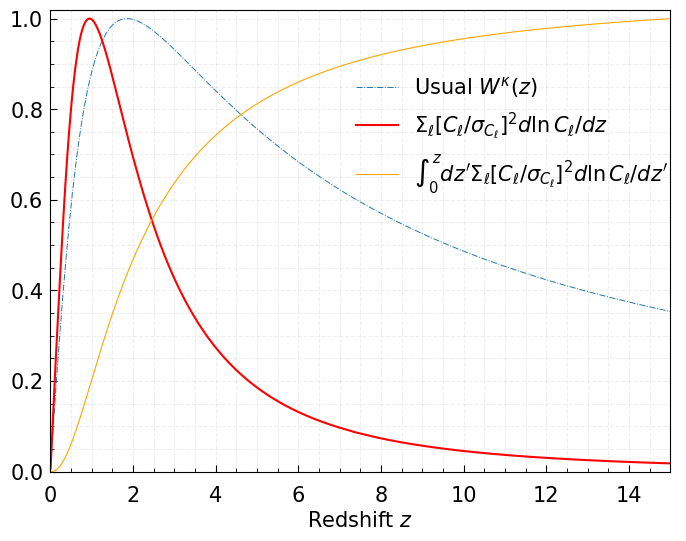

In [381]:
plt.plot(zwz,wz_trad/wz_trad.max(),label='Usual $W^{\kappa}(z)$',ls='-.',lw=0.7)
plt.plot(z_array_2d,wz_dataweighted,label=r'$\Sigma_\ell [C_\ell/\sigma_{C_\ell}]^2 d\ln C_\ell/dz$',c='r')
# plt.plot(z_array_2d,wz_notdataweighted,label=r'$\Sigma_\ell d\ln C^{\kappa\kappa}_\ell/dz$',c='r',lw=0.5,ls=':')

totc = np.trapz(wz_dataweighted,z_array_2d)
wz_dataweighted_c =[]
for zp in z_array_2d:
    wz_dataweighted_c.append(np.trapz(wz_dataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
plt.plot(z_array_2d,wz_dataweighted_c,label='$\int_0^z dz^\prime \Sigma_\ell [C_\ell/\sigma_{C_\ell}]^2 d\ln C_\ell/dz^\prime$',c='orange',lw=0.8)

# totc = np.trapz(wz_notdataweighted,z_array_2d)
# wz_notdataweighted_c =[]
# for zp in z_array_2d:
#     wz_notdataweighted_c.append(np.trapz(wz_notdataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
# plt.plot(z_array_2d,wz_notdataweighted_c,label='$\int_0^z dz^\prime \Sigma_\ell d\ln C_\ell/dz^\prime$',c='orange',lw=0.5,ls='--')


plt.legend(frameon=False,loc=(0.48,0.58),fontsize = 15)
plt.xlabel('Redshift $z$')
# plt.ylabel('Normalized CMB lensing kernel')
plt.ylim(0.,1.02)
plt.xlim(0.,15.)
plt.savefig('figures/lensing_kernel_weighted_log_nonorm_nothinlines.pdf')

In [279]:
import scipy
wlweighted = interp1d(z_array_2d,wz_dataweighted_c)
def f(x):
    return wlweighted(x) - 0.5
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('50% of signal',sol)
def f(x):
    return wlweighted(x) - 0.67
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('67% of signal',sol)
def f(x):
    return wlweighted(x) - 0.90
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('90% of signal',sol)
def f(x):
    return wlweighted(x) - 0.95
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('95% of signal',sol)

50% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 2.1588005138264554
67% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 3.2709393568023217
90% of signal       converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 7.191363775249337
95% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 9.60608761527487


In [280]:
def f(x):
    return wlweighted(x) - (0.5-0.67/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5-0.67/2.))
print(sol)
def f(x):
    return wlweighted(x) - (0.5+0.67/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5+0.67/2.))
print(sol)

0.165 of signal
      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.8796833849887494
0.835 of signal
      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 5.441655213239805


In [281]:
def f(x):
    return wlweighted(x) - (0.5-0.95/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5-0.67/2.))
print(sol)
def f(x):
    return wlweighted(x) - (0.5+0.95/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5+0.95/2.))
print(sol)

0.165 of signal
      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.3275008509339041
0.975 of signal
      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 11.64414805203522


In [282]:
def f(x):
    return wlweighted(x) - 0.25
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('25% of signal',sol)
def f(x):
    return wlweighted(x) - 0.75
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('75% of signal',sol)

25% of signal       converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 1.16052772055079
75% of signal       converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 4.094374938543305


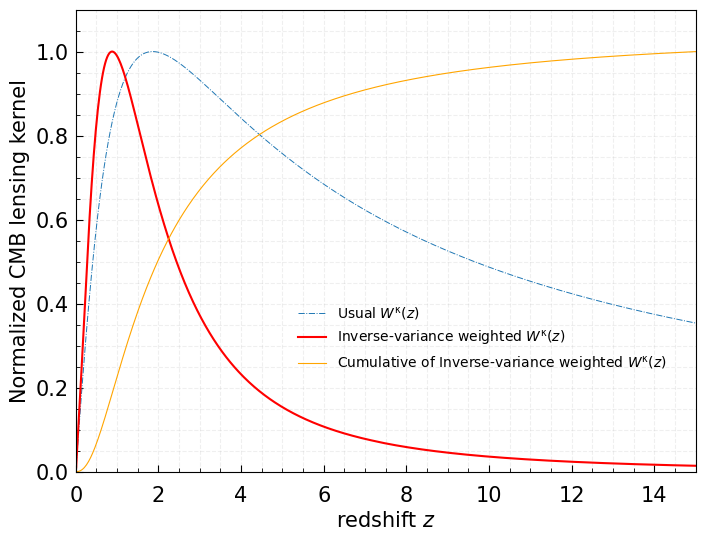

In [241]:
plt.plot(zwz,wz_trad/wz_trad.max(),label='Usual $W^\mathrm{\kappa}(z)$',ls='-.',lw=0.7)
plt.plot(z_array_2d,wz_dataweighted,label='Inverse-variance weighted $W^\mathrm{\kappa}(z)$',c='r')
totc = np.trapz(wz_dataweighted,z_array_2d)
wz_dataweighted_c =[]
for zp in z_array_2d:
    wz_dataweighted_c.append(np.trapz(wz_dataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
plt.plot(z_array_2d,wz_dataweighted_c,label='Cumulative of Inverse-variance weighted $W^\mathrm{\kappa}(z)$',c='orange',lw=0.8)
plt.legend(frameon=False,loc=(0.35,0.2),fontsize = 10)
plt.xlabel('redshift $z$')
plt.ylabel('Normalized CMB lensing kernel')
plt.ylim(0.,1.1)
plt.xlim(0.,15.)
plt.savefig('figures/lensing_kernel_weighted_nolog_nonorm.pdf')

In [245]:
import scipy
wlweighted = interp1d(z_array_2d,wz_dataweighted_c)
def f(x):
    return wlweighted(x) - 0.5
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('50% of signal',sol)
def f(x):
    return wlweighted(x) - 0.67
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('67% of signal',sol)
def f(x):
    return wlweighted(x) - 0.90
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('90% of signal',sol)
def f(x):
    return wlweighted(x) - 0.95
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('95% of signal',sol)

50% of signal       converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 1.979729676520964
67% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 2.9934421742546444
90% of signal       converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 6.679588959291703
95% of signal       converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 9.077446324559958


In [262]:
0.5-0.67/2.

0.16499999999999998

In [263]:
0.5+0.67/2.

0.835

In [271]:
def f(x):
    return wlweighted(x) - (0.5-0.67/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5-0.67/2.))
print(sol)
def f(x):
    return wlweighted(x) - (0.5+0.67/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5+0.67/2.))
print(sol)

0.165 of signal
      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.8177441182869669
0.835 of signal
      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 5.0068474272853525


In [273]:
def f(x):
    return wlweighted(x) - (0.5-0.95/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5-0.67/2.))
print(sol)
def f(x):
    return wlweighted(x) - (0.5+0.95/2.)
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('%.3f of signal'%(0.5+0.95/2.))
print(sol)

0.165 of signal
      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3153451344539745
0.975 of signal
      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 11.208224778901446


In [261]:
def f(x):
    return wlweighted(x) - 0.25
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('25% of signal',sol)
def f(x):
    return wlweighted(x) - 0.75
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 15], method='brentq')
print('75% of signal',sol)

25% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 1.0728099968299778
75% of signal       converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 3.7504198358018903


(0.0, 8.0)

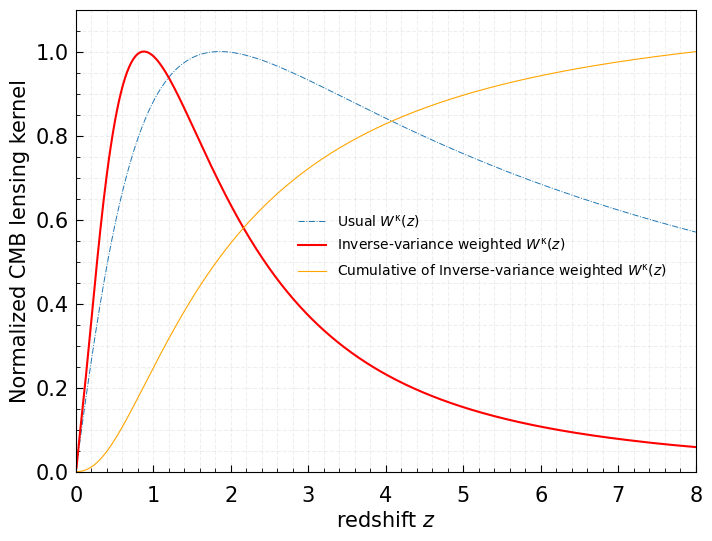

In [217]:
plt.plot(zwz,wz_trad/wz_trad.max(),label='Usual $W^\mathrm{\kappa}(z)$',ls='-.',lw=0.7)
plt.plot(z_array_2d,wz_dataweighted,label='Inverse-variance weighted $W^\mathrm{\kappa}(z)$',c='r')
totc = np.trapz(wz_dataweighted,z_array_2d)
wz_dataweighted_c =[]
for zp in z_array_2d:
    wz_dataweighted_c.append(np.trapz(wz_dataweighted[z_array_2d<zp],z_array_2d[z_array_2d<zp])/totc)
plt.plot(z_array_2d,wz_dataweighted_c,label='Cumulative of Inverse-variance weighted $W^\mathrm{\kappa}(z)$',c='orange',lw=0.8)
plt.legend(frameon=False,loc=(0.35,0.4),fontsize = 10)
plt.xlabel('redshift $z$')
plt.ylabel('Normalized CMB lensing kernel')
plt.ylim(0.,1.1)
plt.xlim(0.,8.)
# plt.savefig('figures/lensing_kernel_weighted_nolog_nonorm.pdf')

In [223]:
import scipy
wlweighted = interp1d(z_array_2d,wz_dataweighted_c)
def f(x):
    return wlweighted(x) - 0.5
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 8], method='brentq')
print('50% of signal',sol)
def f(x):
    return wlweighted(x) - 0.5
sol = scipy.optimize.root_scalar(f, bracket=[0.01, 8], method='brentq')
print('50% of signal',sol)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 1.8183885579079102


In [274]:
z_array_2d[np.where(wz_dataweighted==wz_dataweighted.max())[0]]

array([0.88587646])

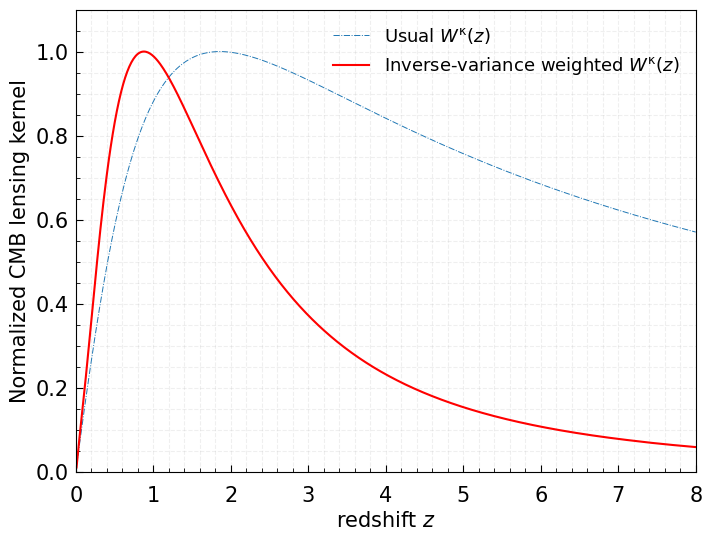

In [201]:
plt.plot(zwz,wz_trad/wz_trad.max(),label='Usual $W^\mathrm{\kappa}(z)$',ls='-.',lw=0.7)
plt.plot(z_array_2d,wz_dataweighted,label='Inverse-variance weighted $W^\mathrm{\kappa}(z)$',c='r')
plt.legend(frameon=False,loc=1)
plt.xlabel('redshift $z$')
plt.ylabel('Normalized CMB lensing kernel')
plt.ylim(0.,1.1)
plt.xlim(0.,8.)
plt.savefig('figures/lensing_kernel_weighted.pdf')

In [156]:
z_array_2d[np.where(wz_dataweighted==wz_dataweighted.max())[0]]

array([0.95706177])

# lensing kernel - just P(k)

In [166]:
%%time
z_array_2d = np.linspace(0.01,5,500)
l = np.linspace(2,100,500)
kappa_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in l:
        chi = M.angular_distance(zp)*(1+zp)*M.h()
        kl = (lm+0.5)/chi
        kappa_2d[izp][ilq] = pknl(kl,zp)
        ilq+=1
    izp+=1

CPU times: user 2 s, sys: 19.3 ms, total: 2.02 s
Wall time: 2.02 s


In [167]:
kappa_2d.min()

77.82360333431201

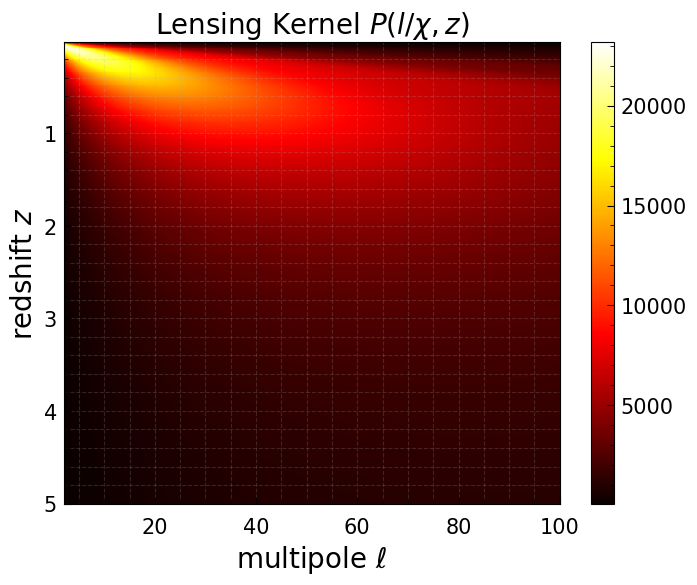

In [168]:
import matplotlib.colors as colors
im = plt.imshow(kappa_2d, cmap='hot', 
                interpolation='nearest',
                # norm=colors.LogNorm(vmin=kappa_2d.min(), vmax=kappa_2d.max()),
                extent = [l[0],l[-1],z_array_2d[-1],z_array_2d[0]],
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
# cbar.set_label('dy/dzdm',size=18)
plt.xlabel('multipole $\ell$',size=20)
plt.ylabel('redshift $z$',size=20)
# plt.show()
plt.title('Lensing Kernel $P(l/\chi,z)$')
plt.savefig('figures/kappa_kernel_Pk_heatmap.pdf')